# Introduction

This notebook will demonstrate how to create a basic recommender system (RS) for books. The RS will take as input a historic set of book ratings from multiple reviewers. For a given book it then suggests what other books might be interesting. We find this in some online shops as well.

The notebook is build up as follows:
1. A little background on Recommender Systems
2. Data inspection and data preparation
3. Building the Recommender System
4. Scoring the Recommender System
5. Evaluate the quality

This notebook is by no means complete. The purpose is to give a quick hands-on experience with building a data product.

## 1. Recommender System types

The essence of a RS is to select items an user is most likely interested in. RS exist in many different forms but we can group them into three sets:

- Collaborative filtering
- Content based filtering
- Hybrid forms

### Collaborative Filtering

Collaborative Filtering RS uses the 'wisdom of the crowd' principle and are found in two flavors: User Based and Item Based. The input of Collaborative Filtering RS is a user-item matrix with ratings of users for several items. Both RS recommend items by finding similarities between users or items respectively based on the ratings. The assumption is that if you like an item then you probably will like similar items too, or you will like what other people like who share a similar item preference.

The key here is similarity.

**Item-based** RS are easier to use because the similarities can be calculated in adcance but are of lower quality than User based models. They are mostly found in online systems shops.

**User-based** RS are more accurate but do not scale well as the complexity and required computation power increases when more users are used as reference.

### Content based filtering

Content based models focus on user profiles and item descriptions, for its recommendations. These models typically try to recommend items that are similar to what a user has liked in the past.

### Hybrid

Combinations of Collaborative Filtering and Content based filtering can be used to use the best of both worlds and to improve the quality of the RS. It seems that these types of RS are most effective of the three.

## 2. Inspect data and prepare the data

We are going the create a book recommender and for that we need user ratings. We will use a dataset from [Book-Crossing](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) but this one is already transformed into usable user-book-rating records. So the hard work has been done. ;-)

We also have to think about how we will evaluate the performance of our RS in the end and therefore how to prepare the data.

As a start we import some python libraries that we require for our prototype.

In [1]:
# Import some important libraries
import pandas as pd
import numpy as np
#import json
%matplotlib inline

Lets read-in the data and show the 5 rows to see how the data looks like.

In [2]:
data = pd.read_csv("data_books.csv", sep = ",", header=None,
                         names=['Reviewer', 'Book', 'Rating'])

# Let's see how the dataframe looks like
data.head()

,Reviewer,Book,Rating
0,276726,Rites of Passage,5
1,276729,Help!: Level 1,3
2,276729,The Amsterdam Connection : Level 4 (Cambridge ...,6
3,276744,A Painted House,7
4,276747,Little Altars Everywhere,9


Lets get some figures about the data:
- What is the size of the data?
- How many unique books and unique reviewers?
- How sparse is the user-item matrix?

In [3]:
# Get the dimensions of the dataframe
dim = data.shape
print ("There are {:d} rows in this dataframe and {:d} features.".format(dim[0], dim[1]))

There are 383852 rows in this dataframe and 3 features.


In [4]:
unique_books = pd.unique(data[['Book']].values.ravel()).size
print ("{:d} unique books.".format(unique_books))

135394 unique books.


In [5]:
unique_reviewers = pd.unique(data[['Reviewer']].values.ravel()).size
print ("{:d} unique reviewers.".format(unique_reviewers))

68092 unique reviewers.


To see how sparse the matrix is, we calculate the fraction of non-zero cells in the matrix.

In [6]:
# Total matrix would be
total_cells = unique_reviewers * unique_books

# How sparse is the matrix now
perc = dim[0] / float(total_cells) * 100.
print ('{:.4f}%'.format(perc))

0.0042%


 **Exercise**: How can we evaluate the performance of a top-N recommender system? And how should we handle the data?

>* Take out random items (rated) per user and check if the recommender will recommend that item. --> Hit Rate
* To be more precise we should take into account the recommended position --> Average Reciprocal Hit Range
* Sort groups high to low
* Pick top row for test
* Pick rest for train

In [7]:
grouped = data.groupby(['Reviewer'])

Split the data and store the training and testing data as files.

In [ ]:
train = pd.DataFrame()
test = pd.DataFrame()

# Walk over all sub groups
for k, g in grouped:
    # We are only interested in reviewers with more than 2 reviews
    if len(g) > 2:
        print k
        g.sort_values('Rating', ascending=False, inplace=True)
        test = test.append(g.iloc[:1])
        train = train.append(g.iloc[1:])
        
train.to_csv('train_books.csv', index=False)
test.to_csv('test_books.csv', index=False)

In [11]:
print ('Train: {:d}, Test: {:d}'.format(train.shape[0], test.shape[0]))

Train: 307086, Test: 20194


In [13]:
train = pd.read_csv("train_books.csv", sep = ",")
test = pd.read_csv("test_books.csv", sep = ",")

## 3. Building the Recommender System

Before we build the end product, we will take small steps in order to gradually create a RS.

Determine the amount of reviews per book and show the top 20.

In [4]:
# Top 20 most reviewed books 
top_books = pd.value_counts(data.Book)
top_books.head(20)

The Lovely Bones: A Novel                                           707
Wild Animus                                                         581
The Da Vinci Code                                                   494
The Secret Life of Bees                                             406
The Nanny Diaries: A Novel                                          393
The Red Tent (Bestselling Backlist)                                 383
Bridget Jones's Diary                                               377
A Painted House                                                     366
Life of Pi                                                          336
Harry Potter and the Chamber of Secrets (Book 2)                    326
Divine Secrets of the Ya-Ya Sisterhood: A Novel                     323
Angels &amp                                                         317
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    315
The Summons                                                     

In [20]:
#####
# Top 20 most reviewed books 
top_books = pd.value_counts(train.Book)
top_books.head(20)

The Lovely Bones: A Novel                                           410
The Da Vinci Code                                                   316
Wild Animus                                                         315
Bridget Jones's Diary                                               272
The Nanny Diaries: A Novel                                          262
The Secret Life of Bees                                             253
Harry Potter and the Chamber of Secrets (Book 2)                    250
Angels &amp                                                         238
A Painted House                                                     233
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    231
Harry Potter and the Prisoner of Azkaban (Book 3)                   229
Life of Pi                                                          225
The Red Tent (Bestselling Backlist)                                 222
Harry Potter and the Goblet of Fire (Book 4)                    

Lets show a graph of the top 1000 most reviewed books.

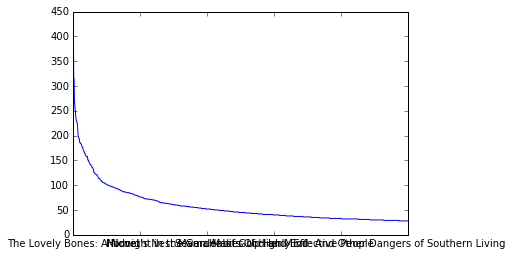

In [21]:
top_books['row'] = range(1, len(top_books) + 1)
top_books[:1000].plot(x=top_books.row)

Now determine how many reviews each user has given.

In [22]:
# Top Reviewers
top_reviewers = pd.value_counts(train.Reviewer)
top_reviewers.head(20)

11676     6942
98391     5690
189835    1898
153662    1844
23902     1179
235105    1019
76499     1011
171118     961
16795      958
248718     940
56399      837
197659     780
35859      776
185233     697
95359      605
114368     602
158295     566
101851     562
177458     523
204864     503
Name: Reviewer, dtype: int64

Wow, there are people that have given almost 7000 reviews! Hmmm, something to investigate later.

# Calculate Similarities

The **Manhattan-distance** which is the sum of the absolute differences along the chosen axis. e.g. when plotted on a graph its the sum of delta y and delta x.

The **Euclidean-distance** which is the most intuitive one and calculated by pythagoras theorem.

The **Pearson-correlation** which is a more complex one. It looks at how two variables changes together relatively to their individuals changes. Values range from -1 to 1.

The **Cosine-similarity** which measures the distance by calculating the angle from the origin. Values range from -1 to 1.


For item based RS the cosine-similarity tends to be the best performing method. For user based RS the Pearson-correlation method works best. In the following steps we will build functions for both.

First we start simple by building an item based version, using Pearson-correlation.

- Choose two books
- Determine their shared reviewers
- Get for each book a list of all reviews of their shared reviewers.
- Calculate the Pearson-correlation over these reviews

In [23]:
# 2 books 
book_1, book_2 = "Harry Potter and the Chamber of Secrets (Book 2)", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"

In [27]:
# Getting all the reviewers for these books
book_1_reviewers = train[train.Book == book_1].Reviewer
book_2_reviewers = train[train.Book == book_2].Reviewer

# Determine any common reviewers
common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

print "%d people have reviewed these 2 books" % len(common_reviewers)

78 people have reviewed these 2 books


In [28]:
# Checking the table with only the common reviewers and get the book name and rating
com_rev_book1 = train[(train.Reviewer.isin(common_reviewers)) & (train.Book == book_1)]
com_rev_book2 = train[(train.Reviewer.isin(common_reviewers)) & (train.Book == book_2)]

In [30]:
com_rev_book1.head(10)

,Reviewer,Book,Rating
14346,10560,Harry Potter and the Chamber of Secrets (Book 2),10
17730,11676,Harry Potter and the Chamber of Secrets (Book 2),10
17701,11676,Harry Potter and the Chamber of Secrets (Book 2),10
17702,11676,Harry Potter and the Chamber of Secrets (Book 2),8
35773,22625,Harry Potter and the Chamber of Secrets (Book 2),10
41851,26190,Harry Potter and the Chamber of Secrets (Book 2),9
48772,30735,Harry Potter and the Chamber of Secrets (Book 2),9
48773,30735,Harry Potter and the Chamber of Secrets (Book 2),9
73532,48899,Harry Potter and the Chamber of Secrets (Book 2),8
76659,51647,Harry Potter and the Chamber of Secrets (Book 2),8


In [31]:
com_rev_book2.head(10)

,Reviewer,Book,Rating
14378,10560,Harry Potter and the Sorcerer's Stone (Harry P...,10
19131,11676,Harry Potter and the Sorcerer's Stone (Harry P...,10
35786,22625,Harry Potter and the Sorcerer's Stone (Harry P...,10
41852,26190,Harry Potter and the Sorcerer's Stone (Harry P...,9
48826,30735,Harry Potter and the Sorcerer's Stone (Harry P...,10
73534,48899,Harry Potter and the Sorcerer's Stone (Harry P...,8
76661,51647,Harry Potter and the Sorcerer's Stone (Harry P...,10
82393,55492,Harry Potter and the Sorcerer's Stone (Harry P...,10
84715,56447,Harry Potter and the Sorcerer's Stone (Harry P...,7
86252,57398,Harry Potter and the Sorcerer's Stone (Harry P...,10


We see duplicate reviewers, that must be fixed to get the Pearson-correlation calculated as the we need to vectors of the same size.

In [32]:
# Fix the duplicates to prevent errors when calculating Pearson-correlation.
com_rev_book1.sort_values('Reviewer')
com_rev_book1 = com_rev_book1[com_rev_book1.Reviewer.duplicated()==False]

com_rev_book1.sort_values('Reviewer')
com_rev_book1 = com_rev_book1[com_rev_book1.Reviewer.duplicated()==False]

In [33]:
import numpy as np

In [34]:
# The Pearson-correlation from the Numpy package
np.corrcoef(com_rev_book1.Rating, com_rev_book2.Rating)[1,0]

0.85749191081587472

Now we have two books that look quit correlated.

In order to apply this calculation to a bigger set of books we need to define two functions that will help us.

1. A function that helps us to retrieve the reviews for a given book while sharing reviewers with another book
2. A function that helps us calculating the Pearson-correlation for two sets of reviews

In [35]:
current_data = train

In [36]:
# Let's create a function that collect the reviews of our common reviewers for a specified book
def get_book_reviews(title, common_reviewers):
    mask = (current_data.Reviewer.isin(common_reviewers)) & (current_data.Book==title)
    reviews = current_data[mask].sort_values('Reviewer')
    reviews = reviews[reviews.Reviewer.duplicated()==False]
    return reviews

In [37]:
def calculate_pearson_correlation(book1, book2):
    # We start by finding the common reviewers
    book_1_reviewers = current_data[current_data.Book == book1].Reviewer
    book_2_reviewers = current_data[current_data.Book == book2].Reviewer
    common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

    # Then we look for the reviews given by common reviewers
    book_1_reviews = get_book_reviews(book1, common_reviewers)
    book_2_reviews = get_book_reviews(book2, common_reviewers)
    
    # Calculate the Pearson Correlation Score
    return np.corrcoef(book_1_reviews.Rating, book_2_reviews.Rating)[1,0]

# Print the correlation score
calculate_pearson_correlation(book_1,book_2)

0.85749191081587472

**Exercise**: build a similar function that calculates the cosine-similarity between two books. The formula for cosine-similarity is:

$$\cos (\theta) = \frac{v \cdot w }{\left \| v \right \|*\left \| w \right \|}$$

In [44]:
def cosin_sim(v, w):
    return np.dot(v, w) / np.math.sqrt(np.dot(v, v) * np.dot(w, w))

def calculate_cosine_similarity(book1, book2):
    # We start by finding the common reviewers
    book_1_reviewers = train[train.Book == book1].Reviewer
    book_2_reviewers = train[train.Book == book2].Reviewer
    common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

    # Then we look for the reviews given by common reviewers
    book_1_reviews = get_book_reviews(book1, common_reviewers)
    book_2_reviews = get_book_reviews(book2, common_reviewers)
    
    # Calculate the Pearson Correlation Score
    return cosin_sim(book_1_reviews.Rating, book_2_reviews.Rating)

# Print the correlation score
calculate_cosine_similarity(book_1,book_2)

0.99734456905443669

## Let's expand the idea to a larger set of books

For performance reasons we will select the top most reviewed books as the calculation of similarity between all book pairs will take too much time. This is the reason why these calculations are executed seperately from the online scoring mechanism.

In [38]:
# As I want to avoid dealing with a huge sparse matrix, I will only select the top most reviewed books for our example 

most_reviewed_books = pd.DataFrame({'count' : train.groupby(["Book"]).size()})\
                                    .reset_index().sort_values(['count'],ascending = False)

most_reviewed_books.head(20)

,Book,count
98216,The Lovely Bones: A Novel,410
91377,The Da Vinci Code,316
118009,Wild Animus,315
14122,Bridget Jones's Diary,272
99750,The Nanny Diaries: A Novel,262
103633,The Secret Life of Bees,253
40289,Harry Potter and the Chamber of Secrets (Book 2),250
7262,Angels &amp,238
2749,A Painted House,233
40317,Harry Potter and the Sorcerer's Stone (Harry P...,231


In [39]:
# Getting the list of the most reviewed books

top_books = []

for i in most_reviewed_books.Book[0:13]:
    top_books.append(i)

    
# calculate the correlation for our top books
correlation_coefficient = []

for book1 in top_books:
    print "Calculating the correlations for:", book1
    for book2 in top_books:
        if book1 != book2:
            row = [book1, book2] + [calculate_pearson_correlation(book1, book2)]
            correlation_coefficient.append(row)

Calculating the correlations for: The Lovely Bones: A Novel
Calculating the correlations for: The Da Vinci Code
Calculating the correlations for: Wild Animus
Calculating the correlations for: Bridget Jones's Diary
Calculating the correlations for: The Nanny Diaries: A Novel
Calculating the correlations for: The Secret Life of Bees
Calculating the correlations for: Harry Potter and the Chamber of Secrets (Book 2)
Calculating the correlations for: Angels &amp
Calculating the correlations for: A Painted House
Calculating the correlations for: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Calculating the correlations for: Harry Potter and the Prisoner of Azkaban (Book 3)
Calculating the correlations for: Life of Pi
Calculating the correlations for: The Red Tent (Bestselling Backlist)


In [40]:
# Let's take a look at what the table of correlation looks like
cols = ["Book_1", "Book_2", "Correlation"]
correlation_coefficient = pd.DataFrame(correlation_coefficient, columns=cols).sort_values('Correlation')
#correlation_coefficient.head(10)

In [41]:
# Let's clean up some of the titles
correlation_coefficient= correlation_coefficient.replace(["The Red Tent (Bestselling Backlist)", "Harry Potter and the Chamber of Secrets (Book 2)",
                                 "Angels &amp", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", "Harry Potter and the Prisoner of Azkaban (Book 3)"],
                                ["The Red Tent", "Harry Potter and the Chamber of Secrets", "Angels & Demons",
                                 "Harry Potter and the Sorcerer's Stone", "Harry Potter and the Prisoner of Azkaban"])

In [42]:
# Also update the top book list
top_books[6] = "Harry Potter and the Chamber of Secrets"
top_books[7] = "Angels & Demons"
top_books[9] = "Harry Potter and the Sorcerer's Stone"
top_books[10] = "Harry Potter and the Prisoner of Azkaban"
top_books[12] = "The Red Tent"

In [45]:
# Helper function to get the correlation between two books
def calc_correlation(corr, book1, book2):
    mask = (corr.Book_1==book1) & (corr.Book_2==book2)
    row = corr[mask]
    corr = row
    return corr.sum(axis=1).tolist()[0]

In [46]:
calc_correlation(correlation_coefficient,"Harry Potter and the Sorcerer's Stone", "The Red Tent")

0.42449996757292047

### Check: Find similar books to "Harry Potter and the Sorcerer's Stone"

In [49]:
# Get the sorted correlations for Harry Potter
my_book = "Harry Potter and the Sorcerer's Stone"

results = []
for b in top_books:
    if my_book!=b:
        results.append((b, calc_correlation(correlation_coefficient, my_book, b)))
sorted(results, key=lambda x: x[1], reverse=True)

[('Harry Potter and the Chamber of Secrets', 0.85749191081587472),
 ('The Nanny Diaries: A Novel', 0.6809065496481953),
 ('Wild Animus', 0.48412291827592707),
 ('Angels & Demons', 0.45363235436327742),
 ('The Red Tent', 0.42449996757292047),
 ('Harry Potter and the Prisoner of Azkaban', 0.33516977212551008),
 ('A Painted House', 0.26363525200414828),
 ('The Lovely Bones: A Novel', 0.18557232038403579),
 ('The Secret Life of Bees', 0.13483997249264842),
 ("Bridget Jones's Diary", 0.026519482723970682),
 ('The Da Vinci Code', -0.10387310073624213),
 ('Life of Pi', -0.27386127875258304)]

**Exercise**: create a function *predict* which takes a book as input and outputs a list with other books, sorted from most correlated to lowest.

In [52]:
def predict(my_book):
    results = []
    for other_book in top_books:
        if my_book != other_book:
            correlation = calc_correlation(correlation_coefficient, my_book, other_book)
            results.append((my_book, other_book, correlation)) 
    return pd.DataFrame.from_dict(sorted(results, key=lambda x: x[2], reverse=True))[:5] 

Now we can test for a given book, what suggestions we should consider.

In [53]:
predict("Harry Potter and the Sorcerer's Stone")

,0,1,2
0,Harry Potter and the Sorcerer's Stone,Harry Potter and the Chamber of Secrets,0.857492
1,Harry Potter and the Sorcerer's Stone,The Nanny Diaries: A Novel,0.680907
2,Harry Potter and the Sorcerer's Stone,Wild Animus,0.484123
3,Harry Potter and the Sorcerer's Stone,Angels & Demons,0.453632
4,Harry Potter and the Sorcerer's Stone,The Red Tent,0.424500


**Question**: What is needed to apply the cosine-similarity function we build before, for this recommender?

## 4. Score

In [ ]:
# Get recommendations for test set


## 5. Evaluate

Hit Rate and Average Reciprocal Hit Range functions

**Exercise**: How to improve the Item-based recommender system?

**Exercise**: Based on the above, create an User-based recommender system?

## References

- Part of the code is from: http://www.mickaellegal.com/blog/2014/1/30/how-to-build-a-recommender
- CF technique backgrounds are explained at http://www.hindawi.com/journals/aai/2009/421425/
- Item-Based Top-N Recommendation Algorithms (Deshpande and Karypis)
